ANALISIS DE EQUIDAD - FAIRNESS DEL MODELO

[1/5] Cargando modelo y datos...
  Test set: (13741, 84)
  Grupos disponibles: ['area', 'departamento', 'sector']

[2/5] Calculando métricas globales...
  Accuracy global: 0.9445
  ROC-AUC global: 0.9845

[3/5] Analizando equidad por grupos...

  Análisis por Área:
    18.0: n=609, Acc=0.944, AUC=0.983
    70.0: n=858, Acc=0.978, AUC=0.997
    68.0: n=809, Acc=0.944, AUC=0.987
    20.0: n=550, Acc=0.933, AUC=0.977
    17.0: n=513, Acc=0.930, AUC=0.979
    50.0: n=566, Acc=0.852, AUC=0.956
    44.0: n=537, Acc=0.955, AUC=0.991
    76.0: n=756, Acc=0.940, AUC=0.963
    13.0: n=822, Acc=0.968, AUC=0.972
    1.0: n=200, Acc=0.925, AUC=0.981
    63.0: n=389, Acc=0.956, AUC=0.994
    5.0: n=809, Acc=0.958, AUC=0.981
    11.0: n=365, Acc=0.929, AUC=0.970
    47.0: n=683, Acc=0.965, AUC=0.984
    19.0: n=536, Acc=0.953, AUC=0.985
    52.0: n=1051, Acc=0.963, AUC=0.991
    66.0: n=475, Acc=0.909, AUC=0.991
    15.0: n=365, Acc=0.929, AUC=0.983
    27.0

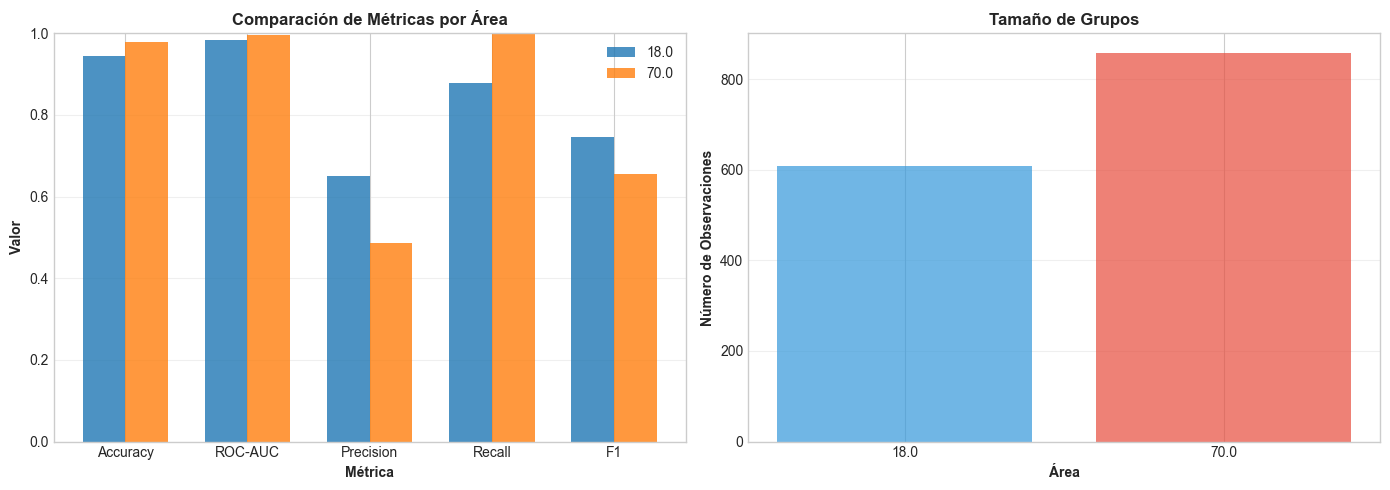

11_equidad_area.png


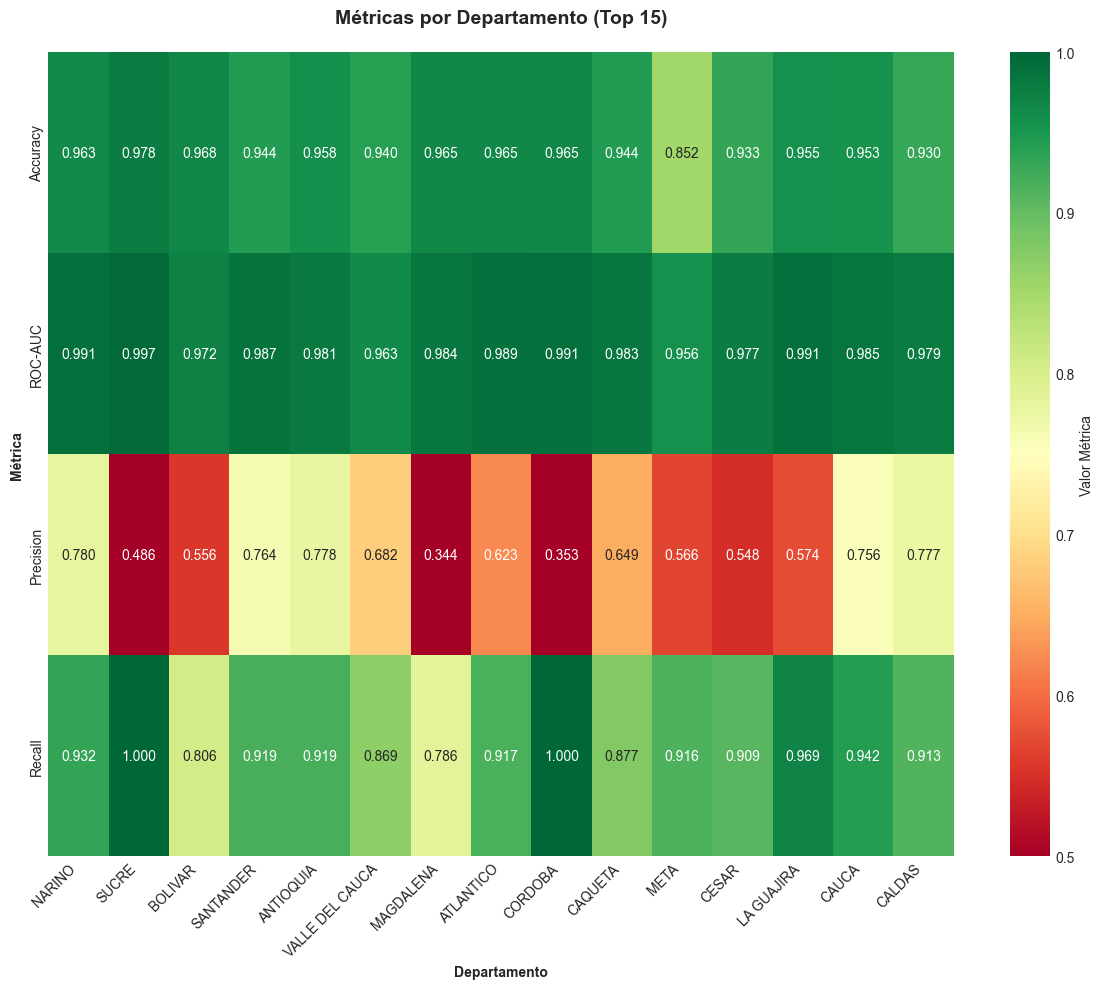

12_equidad_departamentos.png
13_equidad_sectores.png

GUARDANDO ANALISIS DE EQUIDAD
analisis_equidad.pkl
equidad_area.csv
equidad_departamento.csv
equidad_sector.csv

RESUMEN ANALISIS DE EQUIDAD

Métricas Globales:
  Accuracy: 0.9445
  ROC-AUC: 0.9845

Disparate Impact:

  sector: 0.674 DISPARIDAD

Gráficas generadas:
  - 11_equidad_area.png (urbano vs rural)
  - 12_equidad_departamentos.png (mapa de calor)
  - 13_equidad_sectores.png (por sector económico)

Archivos CSV:
  - equidad_area.csv
  - equidad_departamento.csv
  - equidad_sector.csv

ANALISIS DE EQUIDAD COMPLETADO



In [7]:

"""
ANALISIS DE EQUIDAD
Evaluar fairness y disparidades del modelo por grupos
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, 
                             recall_score, f1_score, confusion_matrix)
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ANALISIS DE EQUIDAD - FAIRNESS DEL MODELO")
print("="*80)

OUTPUT_DIR = 'output_ml_final'

# =============================================================================
# PASO 1: CARGAR MODELO Y DATOS
# =============================================================================

print("\n[1/5] Cargando modelo y datos...")

# Cargar modelo
with open(f'{OUTPUT_DIR}/model_balanceado.pkl', 'rb') as f:
    model = pickle.load(f)

# Cargar datos
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_indices.csv')

# Recrear preprocesamiento
df['exito_formalizacion'] = (df['formalidad_laboral'] >= 1).astype(int)

cols_drop = ['exito_ingresos', 'formalidad_laboral']
cols_drop = [c for c in cols_drop if c in df.columns]

y = df['exito_formalizacion']
X = df.drop(['exito_formalizacion'] + cols_drop, axis=1)

# Guardar variables de grupo ANTES de preprocesar
grupos = {}
if 'area' in df.columns:
    grupos['area'] = df['area'].copy()
if 'nombre_departamento' in df.columns:
    grupos['departamento'] = df['nombre_departamento'].copy()
if 'sector_economico' in df.columns:
    grupos['sector'] = df['sector_economico'].copy()

# Preprocesar
num_cols = X.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('Desconocido')
    X[col] = X[col].astype('category').cat.codes

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Guardar índices para grupos
grupos_test = {k: v.loc[X_test.index] for k, v in grupos.items()}

print(f"  Test set: {X_test.shape}")
print(f"  Grupos disponibles: {list(grupos_test.keys())}")

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# =============================================================================
# PASO 2: METRICAS GLOBALES
# =============================================================================

print("\n[2/5] Calculando métricas globales...")

metricas_global = {
    'accuracy': accuracy_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0)
}

print(f"  Accuracy global: {metricas_global['accuracy']:.4f}")
print(f"  ROC-AUC global: {metricas_global['roc_auc']:.4f}")

# =============================================================================
# PASO 3: METRICAS POR GRUPO
# =============================================================================

print("\n[3/5] Analizando equidad por grupos...")

resultados_equidad = {}

# Función para calcular métricas por grupo
def calcular_metricas_grupo(y_true, y_pred_grupo, y_proba_grupo):
    if len(y_true) < 10:  # Muy pocos casos
        return None
    
    return {
        'n': len(y_true),
        'balance': y_true.mean(),
        'accuracy': accuracy_score(y_true, y_pred_grupo),
        'roc_auc': roc_auc_score(y_true, y_proba_grupo) if len(np.unique(y_true)) > 1 else np.nan,
        'precision': precision_score(y_true, y_pred_grupo, zero_division=0),
        'recall': recall_score(y_true, y_pred_grupo, zero_division=0),
        'f1': f1_score(y_true, y_pred_grupo, zero_division=0),
        'tpr': recall_score(y_true, y_pred_grupo, zero_division=0),  # True Positive Rate
        'fpr': ((y_pred_grupo == 1) & (y_true == 0)).sum() / max((y_true == 0).sum(), 1)  # False Positive Rate
    }

# Análisis por área (urbano/rural)
if 'area' in grupos_test:
    print("\n  Análisis por Área:")
    resultados_equidad['area'] = {}
    
    for area_val in grupos_test['area'].unique():
        mask = grupos_test['area'] == area_val
        
        metricas = calcular_metricas_grupo(
            y_test[mask],
            y_pred[mask],
            y_proba[mask]
        )
        
        if metricas:
            resultados_equidad['area'][area_val] = metricas
            print(f"    {area_val}: n={metricas['n']}, Acc={metricas['accuracy']:.3f}, AUC={metricas['roc_auc']:.3f}")

# Análisis por departamento
if 'departamento' in grupos_test:
    print("\n  Análisis por Departamento (Top 10):")
    resultados_equidad['departamento'] = {}
    
    for dept in grupos_test['departamento'].unique():
        mask = grupos_test['departamento'] == dept
        
        metricas = calcular_metricas_grupo(
            y_test[mask],
            y_pred[mask],
            y_proba[mask]
        )
        
        if metricas:
            resultados_equidad['departamento'][dept] = metricas
    
    # Mostrar top 10 por tamaño
    dept_sorted = sorted(resultados_equidad['departamento'].items(), 
                        key=lambda x: x[1]['n'], reverse=True)
    for dept, metricas in dept_sorted[:10]:
        print(f"    {dept}: n={metricas['n']}, Acc={metricas['accuracy']:.3f}, AUC={metricas['roc_auc']:.3f}")

# Análisis por sector
if 'sector' in grupos_test:
    print("\n  Análisis por Sector:")
    resultados_equidad['sector'] = {}
    
    for sector_val in grupos_test['sector'].unique():
        mask = grupos_test['sector'] == sector_val
        
        metricas = calcular_metricas_grupo(
            y_test[mask],
            y_pred[mask],
            y_proba[mask]
        )
        
        if metricas:
            resultados_equidad['sector'][sector_val] = metricas
            print(f"    {sector_val}: n={metricas['n']}, Acc={metricas['accuracy']:.3f}, AUC={metricas['roc_auc']:.3f}")

# =============================================================================
# PASO 4: DISPARATE IMPACT
# =============================================================================

print("\n[4/5] Calculando Disparate Impact...")

disparate_impact = {}

# DI para área (urbano vs rural)
if 'area' in resultados_equidad and len(resultados_equidad['area']) == 2:
    areas = list(resultados_equidad['area'].keys())
    tpr_0 = resultados_equidad['area'][areas[0]]['tpr']
    tpr_1 = resultados_equidad['area'][areas[1]]['tpr']
    
    di = min(tpr_0, tpr_1) / max(tpr_0, tpr_1) if max(tpr_0, tpr_1) > 0 else 1.0
    disparate_impact['area'] = di
    
    print(f"\n  Disparate Impact (Área):")
    print(f"    Ratio: {di:.3f}")
    if di < 0.8:
        print(f"DISPARIDAD SIGNIFICATIVA (< 0.8)")
    else:
        print(f"Disparidad aceptable (>= 0.8)")

# DI para sectores (comparar sector más grande vs más pequeño)
if 'sector' in resultados_equidad and len(resultados_equidad['sector']) > 1:
    sectores_sorted = sorted(resultados_equidad['sector'].items(), 
                            key=lambda x: x[1]['n'], reverse=True)
    
    if len(sectores_sorted) >= 2:
        sector_grande = sectores_sorted[0]
        sector_pequeno = sectores_sorted[-1]
        
        tpr_grande = sector_grande[1]['tpr']
        tpr_pequeno = sector_pequeno[1]['tpr']
        
        di_sector = min(tpr_grande, tpr_pequeno) / max(tpr_grande, tpr_pequeno) if max(tpr_grande, tpr_pequeno) > 0 else 1.0
        disparate_impact['sector'] = di_sector
        
        print(f"\n  Disparate Impact (Sectores):")
        print(f"    {sector_grande[0]} vs {sector_pequeno[0]}")
        print(f"    Ratio: {di_sector:.3f}")
        if di_sector < 0.8:
            print(f"DISPARIDAD SIGNIFICATIVA")
        else:
            print(f"Disparidad aceptable")

# =============================================================================
# PASO 5: VISUALIZACIONES
# =============================================================================

print("\n[5/5] Generando visualizaciones...")

plt.style.use('seaborn-v0_8-whitegrid')

# 1. Comparación de métricas por área
if 'area' in resultados_equidad:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    areas = list(resultados_equidad['area'].keys())
    metricas_nombres = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']
    
    # Gráfica izquierda: Barras agrupadas
    x = np.arange(len(metricas_nombres))
    width = 0.35
    
    valores_area0 = [resultados_equidad['area'][areas[0]][m] for m in metricas_nombres]
    valores_area1 = [resultados_equidad['area'][areas[1]][m] for m in metricas_nombres]
    
    axes[0].bar(x - width/2, valores_area0, width, label=str(areas[0]), alpha=0.8)
    axes[0].bar(x + width/2, valores_area1, width, label=str(areas[1]), alpha=0.8)
    
    axes[0].set_xlabel('Métrica', fontweight='bold')
    axes[0].set_ylabel('Valor', fontweight='bold')
    axes[0].set_title('Comparación de Métricas por Área', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1'])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0, 1.0])
    
    # Gráfica derecha: Tamaño de grupos
    axes[1].bar([str(areas[0]), str(areas[1])], 
               [resultados_equidad['area'][areas[0]]['n'], 
                resultados_equidad['area'][areas[1]]['n']], 
               alpha=0.7, color=['#3498db', '#e74c3c'])
    
    axes[1].set_xlabel('Área', fontweight='bold')
    axes[1].set_ylabel('Número de Observaciones', fontweight='bold')
    axes[1].set_title('Tamaño de Grupos', fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/11_equidad_area.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"11_equidad_area.png")

# 2. Mapa de calor por departamento
if 'departamento' in resultados_equidad:
    # Preparar datos
    dept_data = []
    for dept, metricas in resultados_equidad['departamento'].items():
        dept_data.append({
            'Departamento': dept,
            'Accuracy': metricas['accuracy'],
            'ROC-AUC': metricas['roc_auc'],
            'Precision': metricas['precision'],
            'Recall': metricas['recall'],
            'N': metricas['n']
        })
    
    df_dept = pd.DataFrame(dept_data).sort_values('N', ascending=False).head(15)
    
    # Heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    data_heatmap = df_dept[['Accuracy', 'ROC-AUC', 'Precision', 'Recall']].T
    
    sns.heatmap(data_heatmap, annot=True, fmt='.3f', cmap='RdYlGn', 
                xticklabels=df_dept['Departamento'], 
                yticklabels=['Accuracy', 'ROC-AUC', 'Precision', 'Recall'],
                vmin=0.5, vmax=1.0, ax=ax, cbar_kws={'label': 'Valor Métrica'})
    
    ax.set_title('Métricas por Departamento (Top 15)\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('Departamento', fontweight='bold')
    ax.set_ylabel('Métrica', fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/12_equidad_departamentos.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"12_equidad_departamentos.png")

# 3. Análisis de equidad por sector
if 'sector' in resultados_equidad:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    sectores = list(resultados_equidad['sector'].keys())
    
    # Gráfica superior: ROC-AUC por sector
    roc_aucs = [resultados_equidad['sector'][s]['roc_auc'] for s in sectores]
    ns = [resultados_equidad['sector'][s]['n'] for s in sectores]
    
    axes[0].bar(range(len(sectores)), roc_aucs, alpha=0.7, color='#9b59b6')
    axes[0].axhline(y=metricas_global['roc_auc'], color='red', linestyle='--', 
                   label=f'Global: {metricas_global["roc_auc"]:.3f}')
    axes[0].set_xlabel('Sector', fontweight='bold')
    axes[0].set_ylabel('ROC-AUC', fontweight='bold')
    axes[0].set_title('ROC-AUC por Sector Económico', fontweight='bold')
    axes[0].set_xticks(range(len(sectores)))
    axes[0].set_xticklabels(sectores, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Gráfica inferior: Tamaño de grupos
    axes[1].bar(range(len(sectores)), ns, alpha=0.7, color='#2ecc71')
    axes[1].set_xlabel('Sector', fontweight='bold')
    axes[1].set_ylabel('Número de Observaciones', fontweight='bold')
    axes[1].set_title('Tamaño de Muestra por Sector', fontweight='bold')
    axes[1].set_xticks(range(len(sectores)))
    axes[1].set_xticklabels(sectores, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/13_equidad_sectores.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"13_equidad_sectores.png")

# =============================================================================
# GUARDAR RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("GUARDANDO ANALISIS DE EQUIDAD")
print("="*80)

# Guardar resultados
with open(f'{OUTPUT_DIR}/analisis_equidad.pkl', 'wb') as f:
    pickle.dump({
        'resultados': resultados_equidad,
        'disparate_impact': disparate_impact,
        'metricas_global': metricas_global
    }, f)
print(f"analisis_equidad.pkl")

# Exportar a CSV
for grupo, metricas_dict in resultados_equidad.items():
    df_grupo = pd.DataFrame(metricas_dict).T
    df_grupo.to_csv(f'{OUTPUT_DIR}/equidad_{grupo}.csv')
    print(f"equidad_{grupo}.csv")

# =============================================================================
# RESUMEN
# =============================================================================

print("\n" + "="*80)
print("RESUMEN ANALISIS DE EQUIDAD")
print("="*80)

print(f"""
Métricas Globales:
  Accuracy: {metricas_global['accuracy']:.4f}
  ROC-AUC: {metricas_global['roc_auc']:.4f}

Disparate Impact:
""")

for grupo, di in disparate_impact.items():
    status = "DISPARIDAD" if di < 0.8 else "Aceptable"
    print(f"  {grupo}: {di:.3f} {status}")

print(f"""
Gráficas generadas:
  - 11_equidad_area.png (urbano vs rural)
  - 12_equidad_departamentos.png (mapa de calor)
  - 13_equidad_sectores.png (por sector económico)

Archivos CSV:
  - equidad_area.csv
  - equidad_departamento.csv
  - equidad_sector.csv

ANALISIS DE EQUIDAD COMPLETADO
""")

